## Imports

https://www.kaggle.com/mlg-ulb/creditcardfraud

In [34]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import imblearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
plt.style.use("seaborn")
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
import numpy as np

In [35]:
records = pd.read_csv('creditcard.csv', delimiter=',', header=0)
records.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


# Check if data is well-formed

## Distribution of fraudulent vs. good transactions
Very few fraudulent records

In [36]:
records.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [37]:
#records.hist(figsize=(20,20));


list_of_correlations= records.corr(method='pearson')
plt.figure(figsize=(11,7))
sns.heatmap(list_of_correlations,linewidths=0.005,linecolor='k')
plt.title('Correlation Heatmap')
plt.show()

## Normalize data

In [38]:
#Mean normalization
targets = records.pop('Class')
normalized_records=(records-records.mean())/records.std()
#normalized_records.hist(figsize=(20,20));

## Compare hists between classes

In [39]:
records0 = normalized_records[targets==0]
records1 = normalized_records[targets==1]
#records0.hist(figsize=(20,20));

In [40]:
#records1.hist(figsize=(20,20));

print("Differences between fraud and non-fraud:")
for i in records0.keys():
    print("Differences in",i)
    print("Median:", records0[i].median()-records1[i].median())
    print("Mean:", records0[i].mean()-records1[i].mean())
    print("Std:", records0[i].std()-records1[i].std())
    
    print()

In [41]:
top10 = ['V3', 'V4', 'V7', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18']
X = normalized_records[top10].to_numpy()
y = targets.to_numpy()

In [42]:
lrg2 = LogisticRegression()
from sklearn.model_selection import train_test_split

# split scaled
X_train2, X_validation2, y_train2, y_validation2 = train_test_split(X, y, test_size=0.60, random_state=42)
lrg2.fit(X_train2, y_train2)


LogisticRegression()

In [43]:

oversample = imblearn.over_sampling.SMOTE()
X_smote, y_smote = oversample.fit_resample(X, y)

lrg3 = LogisticRegression()

X_train3, X_validation3, y_train3, y_validation3 = train_test_split(X_smote, y_smote, test_size=0.60, random_state=42)
lrg3.fit(X_train3, y_train3)

LogisticRegression()

In [44]:
mlpclassifier = MLPClassifier(hidden_layer_sizes=(5,2))
mlpclassifier.fit(X_train3, y_train3)

MLPClassifier(hidden_layer_sizes=(5, 2))

In [45]:
skf = StratifiedKFold(n_splits=10)
lrg = LogisticRegression()
accuracies = []
for train_index, test_index in tqdm(skf.split(X,y)):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    lrg.fit(X_train, y_train)
    accuracies.append(lrg.score(X_test, y_test))

print("Mean Logistic Regression Accuracy:", np.mean(accuracies))


10it [00:14,  1.42s/it]Mean Logistic Regression Accuracy: 0.9991292340714824



In [46]:
def plot_roc_cur(fper, tper, label="", title="plot title"):
    plt.plot(fper, tper, label=label)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    
def create_roc_curve(preds, targets, label="", title=""):
    all_fpr, all_tpr = [], []
    
    fpr, tpr, thresholds = roc_curve(targets, preds)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_fpr = np.array(all_fpr)
    all_tpr = np.array(tpr)
    
    plot_roc_cur(all_fpr[0], all_tpr, label=label, title=title)

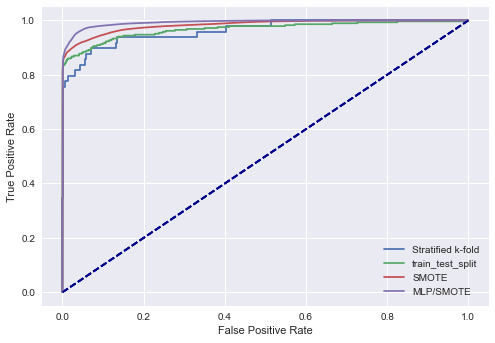

In [47]:
create_roc_curve(lrg.predict_proba(X_test)[:,1], y_test, label="Stratified k-fold")
create_roc_curve(lrg2.predict_proba(X_validation2)[:,1], y_validation2, label="train_test_split")
create_roc_curve(lrg3.predict_proba(X_validation3)[:,1], y_validation3, label="SMOTE")
create_roc_curve(mlpclassifier.predict_proba(X_validation3)[:,1], y_validation3, label="MLP/SMOTE")

In [48]:
lrg.predict_proba(X_test)[:,1].shape

(28480,)

[0.7142153685363561, 0.8076219673034426, 0.9373351512193623, 0.9580122240324591]


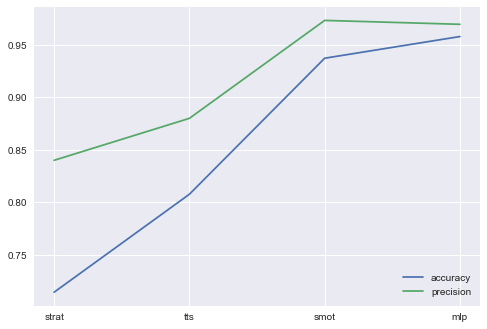

In [57]:
strat = lrg.predict(X_test)
tts = lrg2.predict(X_validation2)
smot = lrg3.predict(X_validation3)
mlp = mlpclassifier.predict(X_validation3)

accur = [roc_auc_score(y_test, strat), roc_auc_score(y_validation2, tts), roc_auc_score(y_validation3, smot), roc_auc_score(y_validation3, mlp)]
precision = [precision_score(y_test, strat), precision_score(y_validation2, tts), precision_score(y_validation3, smot), precision_score(y_validation3, mlp)]

print (accur)

labels = ['strat','tts','smot','mlp']
plt.plot(labels, accur, label="accuracy")
plt.plot(labels, precision, label="precision")
plt.legend(loc='lower right')



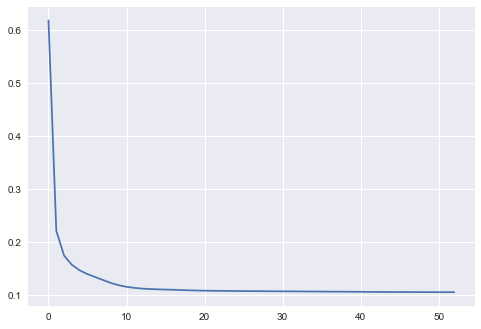

In [56]:
plt.plot(mlpclassifier.loss_curve_)
plt.show()